In [2]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128
EPOCHS = 15

# Shalla
df = pd.read_csv('../train-test/data/shalla_2017.csv.bz2')
df


,domain,shalla_cat
0,nicoleaniston.org,porn
1,gadiz.hotfire.net,porn
2,turismorural.com,recreation/travel
3,esfollandodondesea.blogspot.de,porn
4,oliebollen.com,shopping
...,...,...
1571537,divequest.co.uk,recreation/travel
1571538,wetholeshere.com,porn
1571539,teenbody.com,porn
1571540,sex-free-pic.net,porn


In [3]:
df['cat_count'] = df.shalla_cat.apply(lambda c: len(c.split('|')))
sdf = df[df.cat_count == 1]
sdf

,domain,shalla_cat,cat_count
0,nicoleaniston.org,porn,1
1,gadiz.hotfire.net,porn,1
2,turismorural.com,recreation/travel,1
3,esfollandodondesea.blogspot.de,porn,1
4,oliebollen.com,shopping,1
...,...,...,...
1571537,divequest.co.uk,recreation/travel,1
1571538,wetholeshere.com,porn,1
1571539,teenbody.com,porn,1
1571540,sex-free-pic.net,porn,1


In [4]:
dom_group = sdf.groupby('shalla_cat').agg({'domain': 'count'})
dom_group

,domain
shalla_cat,
adv,12712
aggressive,483
alcohol,638
anonvpn,6981
automobile/bikes,893
...,...
weapons,442
webmail,3525
webphone,49


### Take out categories that have less than 1000 domains.

In [5]:
filter_cat = list(dom_group[dom_group.domain > 1000].index)

### Take out categories that have recall less than 0.3

In [6]:
cmat = """
                   adv       0.77      0.42      0.54      2542
               anonvpn       0.77      0.72      0.75      1396
       automobile/cars       0.48      0.19      0.27       627
                  chat       0.59      0.10      0.17      2686
                dating       0.63      0.11      0.19       519
             downloads       0.58      0.41      0.48       835
                 drugs       0.60      0.24      0.34      2227
               dynamic       0.66      0.51      0.58       213
     education/schools       0.86      0.79      0.82      2014
       finance/banking       0.69      0.56      0.62       998
     finance/insurance       0.90      0.83      0.87       616
  finance/moneylending       0.82      0.80      0.81       760
    finance/realestate       0.61      0.38      0.47       276
        fortunetelling       0.79      0.39      0.52       215
                 forum       0.79      0.75      0.77      1612
                gamble       0.79      0.74      0.76      2765
      hobby/games-misc       0.80      0.04      0.08       378
    hobby/games-online       0.67      0.48      0.56      2772
            hobby/pets       0.65      0.36      0.46      3233
             hospitals       0.87      0.67      0.76       327
             jobsearch       0.84      0.46      0.59       859
                models       0.00      0.00      0.00       345
                movies       0.64      0.54      0.58      1112
                 music       0.83      0.81      0.82      1784
                  news       0.52      0.24      0.33      7668
                others       0.50      0.10      0.16      3011
              politics       0.79      0.22      0.35       258
                  porn       0.86      0.92      0.89    165489
               radiotv       0.58      0.50      0.54       712
recreation/restaurants       0.70      0.26      0.38       282
     recreation/sports       0.62      0.64      0.63     24085
     recreation/travel       0.69      0.66      0.68     27789
            redirector       0.81      0.67      0.73      5873
              religion       0.89      0.81      0.84      1838
     science/astronomy       0.69      0.77      0.73       207
         searchengines       0.57      0.23      0.32       220
          sex/lingerie       0.50      0.35      0.41       211
              shopping       0.50      0.67      0.57     33452
               spyware       0.51      0.22      0.31      3666
               tracker       0.58      0.16      0.25       220
                 warez       0.47      0.16      0.23       374
               webmail       0.80      0.55      0.65       705
              webradio       0.54      0.37      0.44       451
"""

import re

excat = []
for l in cmat.split('\n'):
    a = re.split('\s+', l)
    if len(a) > 1:
        cat = a[1]
        recall = float(a[3])
        if recall < 0.3:
            excat.append(cat)
excat

['automobile/cars',
 'chat',
 'dating',
 'drugs',
 'hobby/games-misc',
 'models',
 'news',
 'others',
 'politics',
 'searchengines',
 'spyware',
 'tracker',
 'warez']

In [7]:
filter_cat = [x for x in filter_cat if x not in excat]
filter_cat

['adv',
 'anonvpn',
 'downloads',
 'dynamic',
 'education/schools',
 'finance/banking',
 'finance/insurance',
 'finance/moneylending',
 'finance/realestate',
 'fortunetelling',
 'forum',
 'gamble',
 'hobby/games-online',
 'hobby/pets',
 'hospitals',
 'jobsearch',
 'movies',
 'music',
 'porn',
 'radiotv',
 'recreation/restaurants',
 'recreation/sports',
 'recreation/travel',
 'redirector',
 'religion',
 'science/astronomy',
 'sex/lingerie',
 'shopping',
 'webmail',
 'webradio']

In [8]:
sdf.loc[sdf.shalla_cat.isin(filter_cat) == False, 'shalla_cat'] = 'others'
sdf

/opt/venv37/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,domain,shalla_cat,cat_count
0,nicoleaniston.org,porn,1
1,gadiz.hotfire.net,porn,1
2,turismorural.com,recreation/travel,1
3,esfollandodondesea.blogspot.de,porn,1
4,oliebollen.com,shopping,1
...,...,...,...
1571537,divequest.co.uk,recreation/travel,1
1571538,wetholeshere.com,porn,1
1571539,teenbody.com,porn,1
1571540,sex-free-pic.net,porn,1


In [9]:
sdf.groupby('shalla_cat').agg({'domain': 'count'})

,domain
shalla_cat,
adv,12712
anonvpn,6981
downloads,4177
dynamic,1066
education/schools,10068
finance/banking,4989
finance/insurance,3081
finance/moneylending,3802
finance/realestate,1379


## Preprocessing the input data

In [10]:
%%time
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1936
CPU times: user 8min 43s, sys: 1.63 s, total: 8min 45s
Wall time: 8min 45s


In [11]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
class_labels = sdf.shalla_cat.astype('category').cat.categories
y = np.array(sdf.shalla_cat.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# backup
y_train_lab = y_train
y_test_lab = y_test

Max feature len = 119, Avg. feature len = 15


In [12]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 2542,
 1: 1396,
 2: 835,
 3: 213,
 4: 2014,
 5: 998,
 6: 616,
 7: 760,
 8: 276,
 9: 215,
 10: 1612,
 11: 2765,
 12: 2772,
 13: 3233,
 14: 327,
 15: 859,
 16: 1112,
 17: 1784,
 18: 22198,
 19: 165489,
 20: 712,
 21: 282,
 22: 24085,
 23: 27789,
 24: 5873,
 25: 1838,
 26: 207,
 27: 211,
 28: 33453,
 29: 705,
 30: 451}

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 10170,
 1: 5585,
 2: 3342,
 3: 853,
 4: 8054,
 5: 3991,
 6: 2465,
 7: 3042,
 8: 1103,
 9: 862,
 10: 6446,
 11: 11062,
 12: 11089,
 13: 12931,
 14: 1310,
 15: 3435,
 16: 4446,
 17: 7134,
 18: 88793,
 19: 661955,
 20: 2848,
 21: 1126,
 22: 96341,
 23: 111154,
 24: 23493,
 25: 7351,
 26: 828,
 27: 845,
 28: 133809,
 29: 2820,
 30: 1803}

## Prepare input sequence

In [14]:
import keras
from keras.preprocessing import sequence

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

n_classes = np.max(y_train) + 1
print(n_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


1230486 train sequences
307622 test sequences
Pad sequences (samples x time)
X_train shape: (1230486, 128)
X_test shape: (307622, 128)
31 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (1230486, 31)
y_test shape: (307622, 31)


## Train Random Forest Model

In [15]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, 
                                  bootstrap = True,
                                  max_features = 'sqrt', random_state=21)
# Fit on training data
rf_model.fit(X_train, y_train_lab)

CPU times: user 12min 14s, sys: 35.3 s, total: 12min 50s
Wall time: 12min 50s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [16]:
%%time
# Actual class predictions
rf_y_pred = rf_model.predict(X_test)
# Probabilities for each class
rf_y_score = rf_model.predict_proba(X_test)

CPU times: user 1min 6s, sys: 3.64 s, total: 1min 10s
Wall time: 1min 10s


## Confusion Matrix

In [17]:
target_names = list(sdf.shalla_cat.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), rf_y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), rf_y_pred))

                        precision    recall  f1-score   support

                   adv       0.93      0.34      0.49      2542
               anonvpn       0.82      0.58      0.68      1396
             downloads       0.66      0.07      0.13       835
               dynamic       0.92      0.28      0.43       213
     education/schools       0.91      0.70      0.79      2014
       finance/banking       0.72      0.21      0.32       998
     finance/insurance       0.99      0.66      0.79       616
  finance/moneylending       0.96      0.54      0.69       760
    finance/realestate       0.57      0.12      0.20       276
        fortunetelling       0.79      0.05      0.10       215
                 forum       0.78      0.19      0.30      1612
                gamble       0.92      0.39      0.55      2765
    hobby/games-online       0.70      0.12      0.21      2772
            hobby/pets       0.78      0.13      0.22      3233
             hospitals       0.90      

## Plot ROC Curve

In [18]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


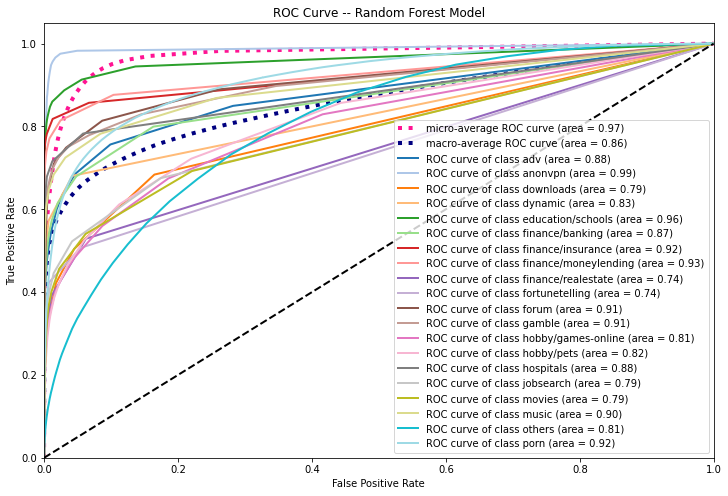

In [19]:
# Compute ROC curve and ROC area for each class
rf_fpr = dict()
rf_tpr = dict()
rf_roc_auc = dict()
for i in range(n_classes):
    rf_fpr[i], rf_tpr[i], _ = roc_curve(y_test[:, i], rf_y_score[:, i])
    rf_roc_auc[i] = auc(rf_fpr[i], rf_tpr[i])
# Compute micro-average ROC curve and ROC area
rf_fpr["micro"], rf_tpr["micro"], _ = roc_curve(y_test.ravel(), rf_y_score.ravel())
rf_roc_auc["micro"] = auc(rf_fpr["micro"], rf_tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
rf_all_fpr = np.unique(np.concatenate([rf_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
rf_mean_tpr = np.zeros_like(rf_all_fpr)
for i in range(n_classes):
    rf_mean_tpr += interp(rf_all_fpr, rf_fpr[i], rf_tpr[i])

# Finally average it and compute AUC
rf_mean_tpr /= n_classes

rf_fpr["macro"] = rf_all_fpr
rf_tpr["macro"] = rf_mean_tpr
rf_roc_auc["macro"] = auc(rf_fpr["macro"], rf_tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(12, 8))
plt.plot(rf_fpr["micro"], rf_tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(rf_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(rf_fpr["macro"], rf_tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(rf_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab20")
colors = cycle([cmap(i) for i in range(n_classes)])

for i, color in zip(range(n_classes), colors):
    plt.plot(rf_fpr[i], rf_tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], rf_roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- Random Forest Model')
plt.legend(loc="lower right")
plt.show()

## Train SVC Model

In [ ]:
%%time
from sklearn.svm import SVC

svc_model = SVC(probability=True, random_state=21, max_iter=500, tol=0.001, verbose=True)
# Fit on training data
svc_model.fit(X_train, y_train_lab)

[LibSVM]

In [ ]:
%%time
# Actual class predictions
svc_y_pred = svc_model.predict(X_test)
# Probabilities for each class
svc_y_score = svc_model.predict_proba(X_test)

## Confusion Matrix

In [26]:
print(classification_report(np.argmax(y_test, axis=1), svc_y_pred, target_names=target_names))
print(confusion_matrix(np.argmax(y_test, axis=1), svc_y_pred))

                        precision    recall  f1-score   support

                   adv       0.02      0.49      0.04      2542
               anonvpn       0.06      0.31      0.11      1396
             downloads       0.00      0.03      0.01       835
               dynamic       0.00      0.00      0.00       213
     education/schools       0.07      0.15      0.09      2014
       finance/banking       0.01      0.02      0.01       998
     finance/insurance       0.10      0.17      0.13       616
  finance/moneylending       0.04      0.11      0.06       760
    finance/realestate       0.01      0.01      0.01       276
        fortunetelling       0.00      0.00      0.00       215
                 forum       0.01      0.02      0.01      1612
                gamble       0.02      0.06      0.03      2765
    hobby/games-online       0.01      0.06      0.02      2772
            hobby/pets       0.02      0.01      0.01      3233
             hospitals       0.11      

## Plot ROC Curve

/opt/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


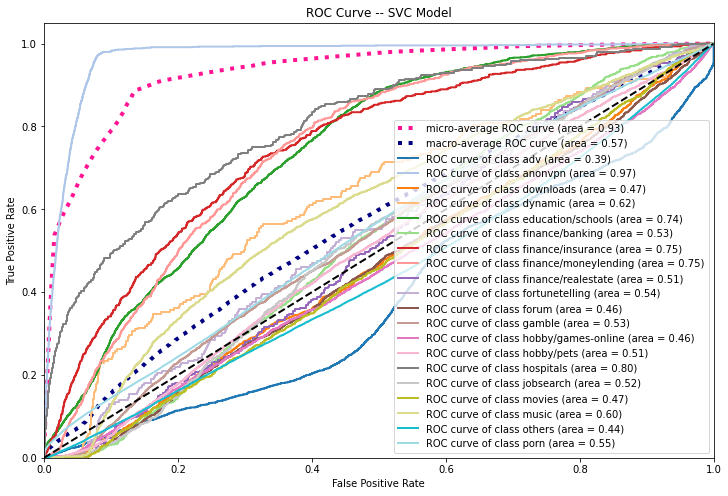

In [27]:
# Compute ROC curve and ROC area for each class
svc_fpr = dict()
svc_tpr = dict()
svc_roc_auc = dict()
for i in range(n_classes):
    svc_fpr[i], svc_tpr[i], _ = roc_curve(y_test[:, i], svc_y_score[:, i])
    svc_roc_auc[i] = auc(svc_fpr[i], svc_tpr[i])
# Compute micro-average ROC curve and ROC area
svc_fpr["micro"], svc_tpr["micro"], _ = roc_curve(y_test.ravel(), svc_y_score.ravel())
svc_roc_auc["micro"] = auc(svc_fpr["micro"], svc_tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
svc_all_fpr = np.unique(np.concatenate([svc_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
svc_mean_tpr = np.zeros_like(svc_all_fpr)
for i in range(n_classes):
    svc_mean_tpr += interp(svc_all_fpr, svc_fpr[i], svc_tpr[i])

# Finally average it and compute AUC
svc_mean_tpr /= n_classes

svc_fpr["macro"] = svc_all_fpr
svc_tpr["macro"] = svc_mean_tpr
svc_roc_auc["macro"] = auc(svc_fpr["macro"], svc_tpr["macro"])

# Plot all ROC curves
plt.figure(1, figsize=(12, 8))
plt.plot(svc_fpr["micro"], svc_tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(svc_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(svc_fpr["macro"], svc_tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(svc_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap("tab20")
colors = cycle([cmap(i) for i in range(n_classes)])
for i, color in zip(range(n_classes), colors):
    plt.plot(svc_fpr[i], svc_tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], svc_roc_auc[i]))
    if i >= 19:
        break

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -- SVC Model')
plt.legend(loc="lower right")
plt.show()


## Save model

In [28]:
import pickle

print('Saving module...')
with open('./models/shalla_cat_2017_svm.pickle', 'wb') as f:
pickle.dump(svc_model, f)

words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./models/shalla_cat_vocab_others_2017.csv', index=False, encoding='utf-8')
pd.DataFrame(target_names, columns=['shalla_cat']).to_csv('./models/shalla_cat_names_others_2017.csv', index=False)

with open('./models/shalla_cat_2017_rf.pickle', 'wb') as f:
  pickle.dump(rf_model, f)